# Image Captioning Model using VGG-16 and LSTM

In [2]:
! pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/adityajn105/flickr8k")

  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105785 sha256=1360e97b7d3bbeafd2f43181e0ab023ba0ef4a295b2868de400ebf9f2c3ec6bc
  Stored in directory: /home/zeus/.cache/pip/wheels/9f/af/22/bf406f913dc7506a485e60dce8143741abd0a92a19337d83a3
Successfully built kaggle
Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k


100%|██████████| 1.04G/1.04G [00:06<00:00, 161MB/s] 


## Import Modules

In [3]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

2024-08-27 17:25:40.845401: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-27 17:25:40.990392: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-27 17:25:41.049306: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-27 17:25:41.066494: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-27 17:25:41.179217: I tensorflow/core/platform/cpu_feature_guar

## Extract Image Features

In [4]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

I0000 00:00:1724779547.969040    7941 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724779548.143121    7941 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724779548.143347    7941 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724779548.145669    7941 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [6]:
# extract features from image
features = {}
directory = 'flickr8k/Images'

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

I0000 00:00:1724779604.732966    9320 service.cc:146] XLA service 0x7f764c009cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724779604.733244    9320 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-08-27 17:26:44.767192: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-27 17:26:44.896211: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
I0000 00:00:1724779607.157998    9320 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [7]:
# store features in pickle
pickle.dump(features, open('features.pkl', 'wb'))

In [8]:
# load features from pickle
with open('features.pkl', 'rb') as f:
    features = pickle.load(f)

features

{'3717809376_f97611ab84': array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 '510791586_3913ade6a7': array([[0.       , 0.       , 0.       , ..., 0.       , 3.4302328,
         0.       ]], dtype=float32),
 '3181701312_70a379ab6e': array([[0.    , 0.    , 0.    , ..., 0.    , 3.3557, 0.    ]],
       dtype=float32),
 '3254817653_632e840423': array([[2.8497267, 2.826215 , 0.       , ..., 0.       , 0.       ,
         0.       ]], dtype=float32),
 '2081615901_13092cac56': array([[2.5377812, 6.645297 , 0.       , ..., 0.       , 0.       ,
         0.       ]], dtype=float32),
 '2060031241_a3ae7a06bb': array([[0.7424126, 1.0715902, 1.748089 , ..., 0.       , 0.       ,
         2.6855857]], dtype=float32),
 '954987350_a0c608b467': array([[0.      , 0.      , 0.      , ..., 0.      , 0.      , 2.728682]],
       dtype=float32),
 '2839932205_3c9c27cd99': array([[0.       , 0.       , 0.       , ..., 0.       , 1.0844681,
         0.       ]], dtype=float32),
 '1410193619_13fff6c875':

## Load the Captions Data

In [9]:
with open("flickr8k/captions.txt", 'r') as f:
    next(f)
    captions_doc = f.read()

In [10]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [11]:
len(mapping)

8091

## Preprocess Text Data

In [12]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [13]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [14]:
# preprocess the text
clean(mapping)

In [15]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [16]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [17]:
len(all_captions)

40455

In [18]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [19]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [20]:
vocab_size

8485

In [21]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## Train Test Split

In [22]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [23]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

## Model Creation

In [24]:
# Encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256,  use_cudnn=False)(se2)


# Decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)


model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')


# plot the model
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [25]:
# train the model
epochs = 35
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 410s 2s/step - loss: 5.7821
227/227 ━━━━━━━━━━━━━━━━━━━━ 36s 156ms/step - loss: 4.0870
227/227 ━━━━━━━━━━━━━━━━━━━━ 36s 156ms/step - loss: 3.5870
227/227 ━━━━━━━━━━━━━━━━━━━━ 35s 155ms/step - loss: 3.2975
227/227 ━━━━━━━━━━━━━━━━━━━━ 35s 156ms/step - loss: 3.0905
227/227 ━━━━━━━━━━━━━━━━━━━━ 35s 156ms/step - loss: 2.9391
227/227 ━━━━━━━━━━━━━━━━━━━━ 35s 153ms/step - loss: 2.8230
227/227 ━━━━━━━━━━━━━━━━━━━━ 35s 153ms/step - loss: 2.7342
227/227 ━━━━━━━━━━━━━━━━━━━━ 35s 153ms/step - loss: 2.6602
227/227 ━━━━━━━━━━━━━━━━━━━━ 35s 154ms/step - loss: 2.5880
227/227 ━━━━━━━━━━━━━━━━━━━━ 35s 155ms/step - loss: 2.5254
227/227 ━━━━━━━━━━━━━━━━━━━━ 36s 157ms/step - loss: 2.4697
227/227 ━━━━━━━━━━━━━━━━━━━━ 35s 156ms/step - loss: 2.4172
227/227 ━━━━━━━━━━━━━━━━━━━━ 36s 157ms/step - loss: 2.3749
227/227 ━━━━━━━━━━━━━━━━━━━━ 35s 155ms/step - loss: 2.3371
  2/227 ━━━━━━━━━━━━━━━━━━━━ 25s 112ms/step - loss: 2.2792

2024-08-27 17:51:53.799312: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 147622596 bytes after encountering the first element of size 147622596 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


227/227 ━━━━━━━━━━━━━━━━━━━━ 36s 158ms/step - loss: 2.2987
227/227 ━━━━━━━━━━━━━━━━━━━━ 36s 156ms/step - loss: 2.2593
227/227 ━━━━━━━━━━━━━━━━━━━━ 35s 156ms/step - loss: 2.2260
227/227 ━━━━━━━━━━━━━━━━━━━━ 36s 158ms/step - loss: 2.1954
227/227 ━━━━━━━━━━━━━━━━━━━━ 36s 159ms/step - loss: 2.1626
227/227 ━━━━━━━━━━━━━━━━━━━━ 36s 158ms/step - loss: 2.1358
227/227 ━━━━━━━━━━━━━━━━━━━━ 36s 159ms/step - loss: 2.1092
227/227 ━━━━━━━━━━━━━━━━━━━━ 36s 160ms/step - loss: 2.0845
227/227 ━━━━━━━━━━━━━━━━━━━━ 36s 160ms/step - loss: 2.0585
227/227 ━━━━━━━━━━━━━━━━━━━━ 36s 157ms/step - loss: 2.0365
227/227 ━━━━━━━━━━━━━━━━━━━━ 36s 160ms/step - loss: 2.0125
227/227 ━━━━━━━━━━━━━━━━━━━━ 37s 161ms/step - loss: 1.9931
227/227 ━━━━━━━━━━━━━━━━━━━━ 37s 163ms/step - loss: 1.9740
227/227 ━━━━━━━━━━━━━━━━━━━━ 36s 161ms/step - loss: 1.9595
227/227 ━━━━━━━━━━━━━━━━━━━━ 37s 161ms/step - loss: 1.9370
227/227 ━━━━━━━━━━━━━━━━━━━━ 36s 159ms/step - loss: 1.9205
227/227 ━━━━━━━━━━━━━━━━━━━━ 36s 160ms/step - loss: 1.90

In [26]:
model.save("model.keras")

## Generate Captions for the Image

In [27]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


In [28]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [29]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.545007
BLEU-2: 0.317127


## Visualize the Results

In [35]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join("flickr8k/Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq


--------------------Predicted--------------------
startseq two dogs are playing tug of war with red object endseq


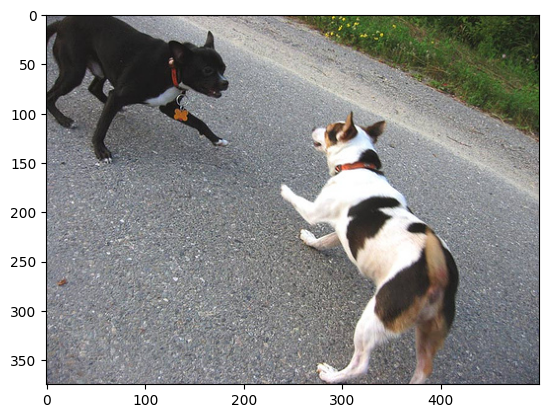

In [36]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq man in field backed by american flags endseq
startseq man is being thrown frisbee in front of monument and flags endseq
startseq man is clapping at the base of the washington memorial endseq
startseq man stands in front of the gateway arch endseq
startseq man tries to catch football on grass surrounded by american flags endseq


--------------------Predicted--------------------
startseq two people are playing with large soccer ball endseq


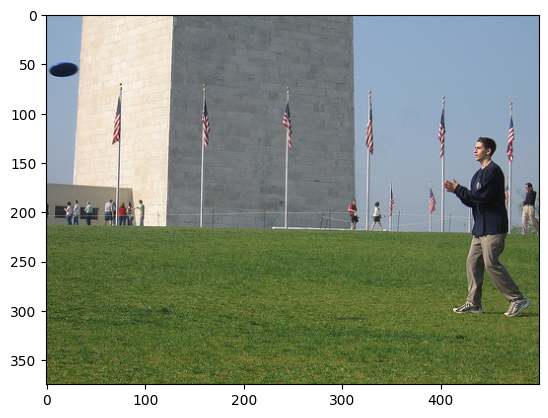

In [37]:
generate_caption("135235570_5698072cd4.jpg")

---------------------Actual---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
startseq two people in red and white jackets and hats and jumping on trampoline endseq


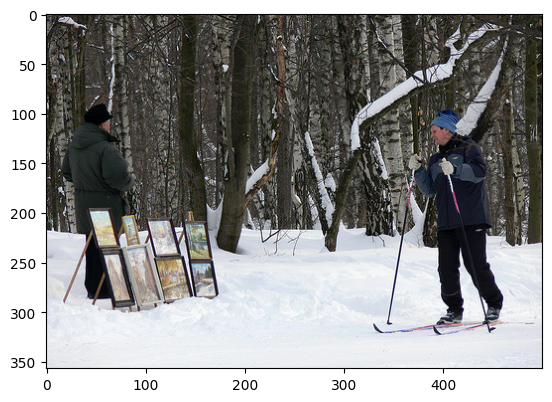

In [38]:
generate_caption("101669240_b2d3e7f17b.jpg")

## Test with Real Image

In [39]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

startseq dog jumps to catch ball endseq


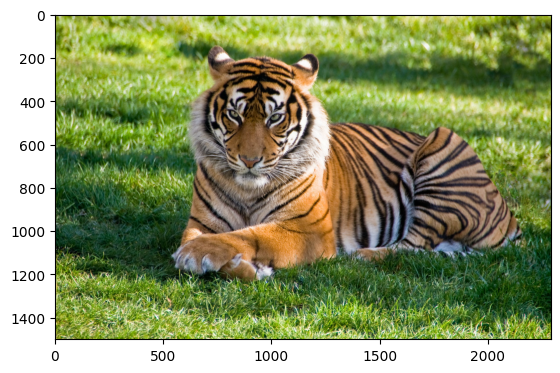

In [45]:
image_path = 'file-6113d5f8845dc.jpeg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
result = predict_caption(model, feature, tokenizer, max_length)

image = Image.open(image_path)
plt.imshow(image)
print(result)